<hr>
<div style="background-color: lightgray; padding: 20px; color: black;">
<div>
<img src="https://th.bing.com/th/id/R.3cd1c8dc996c5616cf6e65e20b6bf586?rik=09aaLyk4hfbBiQ&riu=http%3a%2f%2fcidics.uanl.mx%2fwp-content%2fuploads%2f2016%2f09%2fcimat.png&ehk=%2b0brgMUkA2BND22ixwLZheQrrOoYLO3o5cMRqsBOrlY%3d&risl=&pid=ImgRaw&r=0" style="float: right; margin-right: 30px;" width="200"/>
<font size="5.5" color="8C3061"><b>Modelos implícitos de difusión para eliminación de ruido (DDIM)
 </b></font> <br>
<font size="4.5" color="8C3061"><b>Aprendizaje de Máquina II - Tarea 5 </b></font>
</div>
<div style="text-align: left">  <br>
Edison David Serrano Cárdenas. <br>
MSc en Matemáticas Aplicadas <br>
CIMAT - Sede Guanajuato <br>
</div>

</div>
<hr>


# <font color="8C3061" >**Introducción**</font>


Los modelos de difusión considerados en esta tarea están enfocados a eliminar el ruido de las imágenes, y en generar imágenes eliminando iterativamente el ruido.

# <font color="8C3061" >**Setup**</font>

***Cargar librerías:***

In [6]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

***Configuración de hiperparámetros:***

In [7]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 10  # train for at least 50 epochs for good results
image_size = 32
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 100.0
num_heads = 2  # Número de cabezas de atención
projection_dim = 64  # Dimensión de proyección
transformer_depth = 2  # Profundidad del Transformer

# Diffusion parameters
num_steps = 1000

# optimization
batch_size = 16
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

***Canalización de los datos:***

Usaremos el conjunto de datos
[Oxford Flowers 102](https://www.tensorflow.org/datasets/catalog/oxford_flowers102)
para
generar imágenes de flores, que es un conjunto de datos naturales diverso que contiene alrededor de 8000
imágenes. Se crea nuevas divisiones (80 % de entrenamiento, 20 % de validación) utilizando la
[API de segmentación de conjuntos de datos de Tensorflow](https://www.tensorflow.org/datasets/splits) como es indicado en el código de referencia. Aplicamos
recortes centrales como preprocesamiento y repetimos el conjunto de datos varias veces.

In [8]:
def preprocess_image(data):
    # center crop image
    height = ops.shape(data["image"])[0]
    width = ops.shape(data["image"])[1]
    crop_size = ops.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)

In [9]:
def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

***Cargar Conjunto de Datos:***

In [10]:
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# <font color="8C3061" >**Kernel inception distance**</font>

In [11]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

# <font color="8C3061" >**Arquitectura del Transformer**</font>

Vamos a definir la red neuronal que se usará para la eliminación del ruido. Esta será un *Visual Transformer*. Esta cuenta con entrada y salida con las mismas dimensiones.

In [12]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings

def transformer_block(inputs, num_heads, projection_dim):
    # Normalización y atención multi-cabeza
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x, x)
    x = layers.Add()([x, attention_output])

    # Normalización y feed-forward (MLP)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    mlp_output = layers.Dense(projection_dim * 4, activation="gelu")(x)
    mlp_output = layers.Dense(projection_dim)(mlp_output)
    return layers.Add()([x, mlp_output])

def get_network(image_size, transformer_depth, num_heads, projection_dim):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, embedding_dims))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
    e = layers.Conv2D(projection_dim, kernel_size=1)(e)

    x = layers.Conv2D(projection_dim, kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    # Reshape for Transformer (Flatten the spatial dimensions, keep the projection_dim as features)
    x = layers.Reshape((image_size * image_size, 2*projection_dim))(x)

    for _ in range(transformer_depth):
        x = transformer_block(x, num_heads, 2*projection_dim)

    # Reshape back to image format
    x = layers.Reshape((image_size, image_size, 2*projection_dim))(x)

    # Final convolution to output RGB channels
    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="transformer_image_model")


# <font color="8C3061" >**Modelo de Difusión**</font>

In [13]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, transformer_depth, num_heads, projection_dim):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, transformer_depth, num_heads, projection_dim)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


# <font color="8C3061" >**Entrenamiento**</font>



In [14]:
model = DiffusionModel(image_size, transformer_depth, num_heads, projection_dim)

model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
)

Epoch 1/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 266s 123ms/step - i_loss: 0.5990 - n_loss: 0.3436 - val_i_loss: 0.7215 - val_kid: 0.8684 - val_n_loss: 0.3628
Epoch 2/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 233s 113ms/step - i_loss: 0.4848 - n_loss: 0.3098 - val_i_loss: 0.4802 - val_kid: 0.9145 - val_n_loss: 0.3057
Epoch 3/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 231s 113ms/step - i_loss: 0.4790 - n_loss: 0.3051 - val_i_loss: 0.4630 - val_kid: 0.9431 - val_n_loss: 0.3005
Epoch 4/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 231s 113ms/step - i_loss: 0.4753 - n_loss: 0.3024 - val_i_loss: 0.4542 - val_kid: 0.8730 - val_n_loss: 0.3018
Epoch 5/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 231s 113ms/step - i_loss: 0.4720 - n_loss: 0.3029 - val_i_loss: 0.4610 - val_kid: 0.8691 - val_n_loss: 0.2972
Epoch 6/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 232s 113ms/step - i_loss: 0.4694 - n_loss: 0.3030 - val_i_loss: 0.4584 - val_kid: 0.8595 - val_n_loss: 0.2984
Epoch 7/10
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 263s 114ms/step - i_loss: 0.4664 - n_loss: 0.3

## Inference

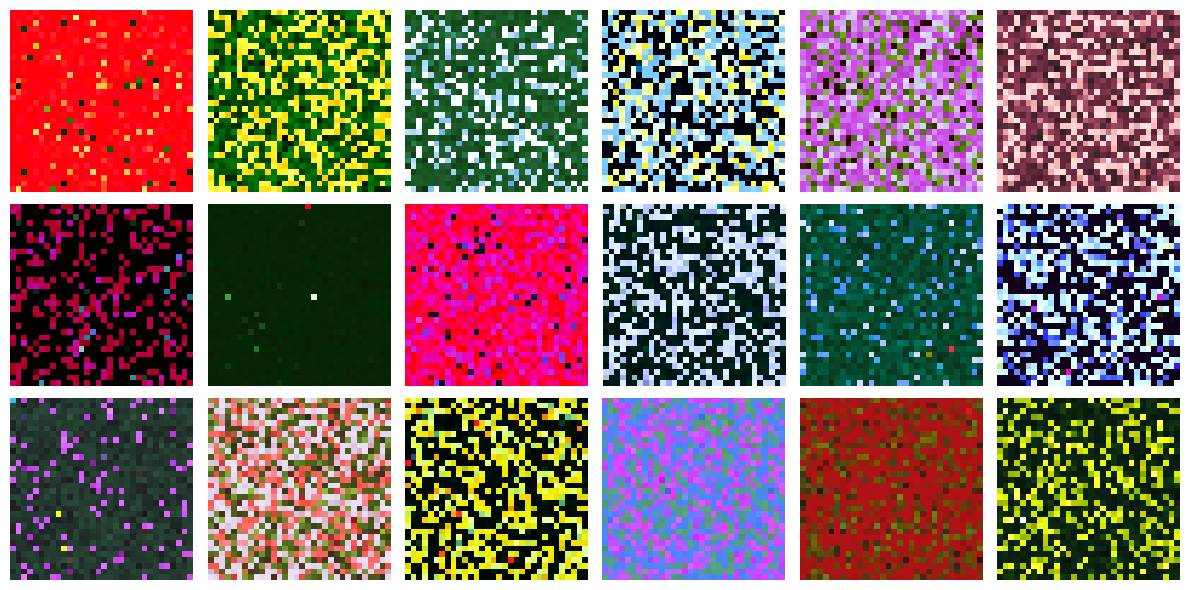

In [16]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()

# <font color="8C3061" >**Conclusiones**</font>

- El modelo no tuvo un buen rendimiento en el proceso de generar nuevas imagenes.
- El costo de entrenar el transformer es muy alto, se tomo a consideración una disminución del tamaño de las imagenes,en el tamaño del batch, en el embedding_max_frequency y en el tamaño de épocas, para que se pudiesen realizar experimentos.
- Es esperado revisar con más detalle la implementación del Transformer para quitar el ruido. En partícular, la función get_network. También es importante analizar la función sinusoidal_embedding.
- Las imagenes presentan una variedad exotica de colores. Rescatando en mucho carácteristicas como color de pétalos, tallos y hojas, pero, no estructuras.
